# Split data

```python
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
```

* train_indices, test_indices : ตัวแปรที่เก็บผลลัพธ์จากการแบ่งข้อมูล
  * train_indices : list ค่าของข้อมูลแต่ละตัวที่ใช้ฝึกโมเดล (Train set)
  * test_indices : list ค่าของข้อมูลแต่ละตัวที่ใช้ทดสอบโมเดล (Test set)
* train_test_split : ฟังก์ชันที่ใช้ในการแบ่งข้อมูลออกเป็น 2 ชุด train/test
* indices : ตัวแปรที่เก็บลิสต์ index ของข้อมูล
* test_size=0.2 : กำหนดสัดส่วนของข้อมูลที่ใช้สำหรับชุด test เป็น 20% ของข้อมูลทั้งหมด
* random_state=42 : กำหนด seed สำหรับสุ่ม (Random Number Generator) เพื่อให้การสุ่มได้ผลลัพธ์เดิมทุกครั้งเมื่อรันโค้ด

<hr>

```python
train_dataset_split = Subset(full_dataset, train_indices)
test_dataset_split = Subset(full_dataset, test_indices)
```

* subset : ใช้สำหรับสร้าง subset (ชุดข้อมูลย่อย) ของ dataset ที่กำหนด
  * คลาสนี้ช่วยดึงข้อมูลเฉพาะบาง indices จาก dataset หลัก (full_dataset) โดยไม่ต้องสร้าง dataset ใหม่
* Subset(full_dataset, train_indices)
  * full_dataset: Dataset หลักที่ต้องการดึงข้อมูล
  * train_indices : ลิสต์ของ indices ที่ระบุว่าต้องการเลือกข้อมูลตัวไหนจาก dataset หลัก

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import ConcatDataset, Subset
import matplotlib.pyplot as plt

# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16,
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3,
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the autoencoder
model = Autoencoder()

# Define transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Load dataset
train_dataset = datasets.Flowers102(root='flowers',
                                     split='train',
                                     transform=transform,
                                     download=True)
test_dataset = datasets.Flowers102(root='flowers',
                                    split='test',
                                    transform=transform)

# Combine datasets
full_dataset = ConcatDataset([train_dataset, test_dataset]) # ใช้ ConcatDataset เพื่อรวม train_dataset และ test_dataset เข้าด้วยกัน

# Split dataset into train and test
dataset_size = len(full_dataset) # หาจำนวนรูปภาพทั้งหมด
indices = list(range(dataset_size)) # สร้างรายการตัวเลขเรียงลำดับตั้งแต่ 0 ถึง dataset_size - 1 เพื่อใช้เป็นดัชนีสำหรับแยกข้อมูล
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Create Subsets
train_dataset_split = Subset(full_dataset, train_indices)
test_dataset_split = Subset(full_dataset, test_indices)

# Define DataLoader
train_loader_split = torch.utils.data.DataLoader(dataset=train_dataset_split,
                                                 batch_size=128,
                                                 shuffle=True)
test_loader_split = torch.utils.data.DataLoader(dataset=test_dataset_split,
                                                batch_size=128)

# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the autoencoder
num_epochs = 1
for epoch in range(num_epochs):
    for data in train_loader_split:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    if epoch % 5 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item()))

# Save the model
torch.save(model.state_dict(), 'conv_autoencoder.pth')

cpu
Epoch [1/1], Loss: 0.0684


<Figure size 1600x1200 with 0 Axes>

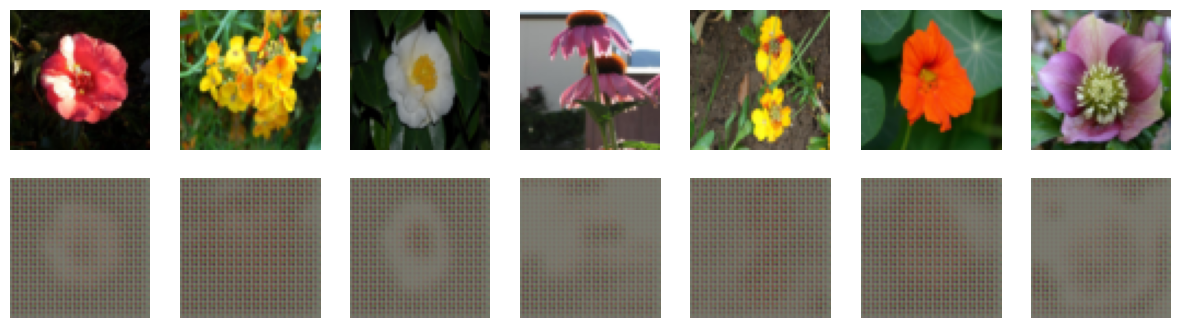

In [4]:
# Visualize results
with torch.no_grad():
    for data, _ in test_loader_split:
        data = data.to(device)
        recon = model(data)
        break

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()